In [1]:
import torch
import torchist
from torchdiffeq import odeint_adjoint as odeint
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import time
import sys
sys.path.append('../')
from typing import Tuple, Any

%load_ext autoreload
%autoreload 2


import interflow as itf
import interflow.prior as prior
import interflow.fabrics
import interflow.stochastic_interpolant as stochastic_interpolant
from torch import autograd
from functorch import jacfwd, vmap


if torch.cuda.is_available():
    print('CUDA available, setting default tensor residence to GPU.')
    itf.util.set_torch_device('cuda')
else:
    print('No CUDA device found!')
print(itf.util.get_torch_device())


print("Torch version:", torch.__version__)

CUDA available, setting default tensor residence to GPU.
cuda
Torch version: 2.4.1+cu121


/home/valeriano/.virtualenvs/torch/lib/python3.10/site-packages/torch/__init__.py:955: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


## Utility functions

In [2]:
def grab(var):
    """Take a tensor off the gpu and convert it to a numpy array on the CPU."""
    return var.detach().cpu().numpy()


def compute_likelihoods(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: int,
    bs: int
) -> Tuple[torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""
    
    pflow = stochastic_interpolant.PFlowIntegrator(b=b,  
                                                  method='dopri5', 
                                                  interpolant=interpolant,
                                                  n_step=3)

    # logp0                  = base.log_prob(x0_tests)            # [bs]
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)            # [n_save x bs x dim], [n_save x bs]
    logpx_pflow            = logp0 + dlogp_pflow[-1].squeeze()  # [bs]
    xf_pflow               = grab(xfs_pflow[-1].squeeze())      # [bs x dim]


    return xf_pflow, logpx_pflow

def compute_likelihoods2(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: int,
    bs: int
) -> Tuple[torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""
    
    
    # sde_flow = stochastic_interpolant.SDEIntegrator(
    #     b=b, s=s, eps=eps, interpolant=interpolant, n_save=n_save, n_likelihood=1, n_step=n_step
    # )
    pflow = stochastic_interpolant.PFlowIntegrator(b=b,  
                                                  method='dopri5', 
                                                  interpolant=interpolant,
                                                  n_step=3)
    
    # with torch.no_grad():
    #     x0_tests  = base(bs)
    #     xfs_sde   = sde_flow.rollout_forward(x0_tests) # [n_save x bs x dim]
    #     xf_sde    = grab(xfs_sde[-1].squeeze())        # [bs x dim]
    #     # ([1, bs, dim], [bs])
    #     x0s_sdeflow, _ = sde_flow.rollout_likelihood(xfs_sde[-1])
    

    logp0                  = base.log_prob(x0_tests)            # [bs]
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)            # [n_save x bs x dim], [n_save x bs]
    logpx_pflow            = logp0 + dlogp_pflow[-1].squeeze()  # [bs]
    xf_pflow               = grab(xfs_pflow[-1].squeeze())      # [bs x dim]


    return x0_tests, xf_sde, xf_pflow, logpx_pflow

def rollout(x0_tests,
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: int,
    bs: int
) -> Tuple[torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""

    pflow = stochastic_interpolant.PFlowIntegrator(b=b,  
                                                  method='dopri5', 
                                                  interpolant=interpolant,
                                                  n_step=3)

    # logp0                  = base.log_prob(x0_tests)            # [bs]
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)            # [n_save x bs x dim], [n_save x bs]
    # logpx_pflow            = logp0 + dlogp_pflow[-1].squeeze()  # [bs]
    xf_pflow               = grab(xfs_pflow[-1].squeeze())      # [bs x dim]

    return x0_tests, xf_pflow

def log_metrics(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    likelihood_bs: int, 
    b_loss: torch.tensor,
    s_loss: torch.tensor,
    loss: torch.tensor,
    b_grad: torch.tensor,
    s_grad: torch.tensor,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    # log loss and gradient data
    b_loss   = grab(b_loss).mean(); data_dict['b_losses'].append(b_loss)
    s_loss   = grab(s_loss).mean(); data_dict['s_losses'].append(s_loss)
    loss     = grab(loss).mean(); data_dict['losses'].append(loss)
    b_grad   = grab(b_grad).mean(); data_dict['b_grads'].append(b_grad)
    s_grad   = grab(s_grad).mean(); data_dict['s_grads'].append(s_grad)

    
    # compute and log likelihood data
    # _, _, logpx_pflow = compute_likelihoods(
    #     b, s, interpolant, n_save, n_step, eps, likelihood_bs)
    
    # logpx_pflow = grab(logpx_pflow).mean(); data_dict['logps_pflow'].append(logpx_pflow)
    
    
def make_plots(
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int, ## number of sde steps in [0,1]
    likelihood_bs: int,
    counter: int,
    metrics_freq: int,
    eps: torch.tensor,
    data_dict: dict
) -> None:
    """Make plots to visualize samples and evolution of the likelihood."""
    # compute likelihood and samples for SDE and probability flow.
    # xf_pflow, logpx_pflow = compute_likelihoods(
    #     b, s, interpolant, n_save, n_step, eps, likelihood_bs
    # )


    ### plot the loss, test logp, and samples from interpolant flow
    fig, axes = plt.subplots(1,4, figsize=(16,4))
    print("EPOCH:", counter)
    print("LOSS, GRAD:", loss, b_grad, s_grad)


    # plot loss over time.
    nsaves = len(data_dict['losses'])
    epochs = np.arange(nsaves)*metrics_freq
    axes[0].plot(epochs, data_dict['losses'], label=" b + s")
    axes[0].plot(epochs, data_dict['b_losses'], label="b")
    axes[0].plot(epochs, data_dict['s_losses'], label = "s" )
    axes[0].set_title("LOSS")
    axes[0].legend()


    # plot samples from pflow
    # axes[2].scatter(
    #     xf_pflow[:,0], xf_pflow[:,1], vmin=0.0, vmax=0.05, alpha = 0.2, c=grab(torch.exp(logpx_pflow).detach()))
    # axes[1].hist(xf_pflow, 10, histtype="step", density=True, lw=3,  label = 'target');
    # axes[1].set_xlim(-5,5)
    # axes[1].set_ylim(-6.5,6.5)
    # axes[1].set_title("Samples from PFlow", fontsize=14)


    # # plot likelihood estimates.
    # axes[3].plot(epochs, data_dict['logps_pflow'],   label='pflow', color='purple')
    # axes[3].set_title(r"$\log p$ from PFlow")
    # axes[3].legend(loc='best')
    # axes[3].set_ylim(-7,0)


    fig.suptitle(r"$\epsilon = $" + str(grab(eps)),  fontsize=16, y = 1.05)
    plt.show()
    
    


def train_step(
    bs: int,
    interpolant: stochastic_interpolant.Interpolant,
    opt_b  : Any,
    opt_s  : Any,
    sched_b: Any, 
    sched_s: Any,
):
    """
    Take a single step of optimization on the training set.
    """
    opt_b.zero_grad()
    opt_s.zero_grad()


    # construct batch
    # x0s = base(bs)
    # x0s = x0s[torch.argsort(((x0s-x0s.mean(0))**2).sum(1))]
    # x1s = target(bs)
    x0s, x1s = gen_samples(torch.rand(1), 10**(-4+torch.rand(1)*3), 1e-4, 16, 500, 1000)
    # x1s = x1s[torch.argsort(((x1s-x1s.mean(0))**2).sum(1))]
    ts  = torch.rand(size=(x0s.shape[0],))


    # compute the loss
    loss_start = time.perf_counter()
    loss_b     = loss_fn_b(b, x0s, x1s, ts, interpolant)
    loss_s     = loss_fn_s(s, x0s, x1s, ts, interpolant)
    loss_val   = loss_b + loss_s
    loss_end   = time.perf_counter()


    # compute the gradient
    backprop_start = time.perf_counter()
    loss_b.backward()
    loss_s.backward()
    b_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(b.parameters(), float('inf'))])
    s_grad = torch.tensor([torch.nn.utils.clip_grad_norm_(s.parameters(), float('inf'))])
    backprop_end = time.perf_counter()


    # perform the update.
    update_start = time.perf_counter()
    opt_b.step()
    opt_s.step()
    sched_b.step()
    sched_s.step()
    update_end = time.perf_counter()


    if counter < 5:
        print(f'[Loss: {loss_end - loss_start}], [Backprop: {backprop_end-backprop_start}], [Update: {update_end-update_start}].')


    return loss_val.detach(), loss_b.detach(), loss_s.detach(), b_grad.detach(), s_grad.detach()

In [3]:
def rollout(x0_tests,
    b: torch.nn.Module,
    s: torch.nn.Module,
    interpolant: stochastic_interpolant.Interpolant,
    n_save: int,
    n_step: int,
    eps: int,
    bs: int
) -> Tuple[torch.tensor, torch.tensor]:
    """Draw samples from the probability flow and SDE models, and compute likelihoods."""

    pflow = stochastic_interpolant.PFlowIntegrator(b=b,  
                                                  method='dopri5', 
                                                  interpolant=interpolant,
                                                  n_step=3)

    # logp0                  = base.log_prob(x0_tests)            # [bs]
    xfs_pflow, dlogp_pflow = pflow.rollout(x0_tests)            # [n_save x bs x dim], [n_save x bs]
    # logpx_pflow            = logp0 + dlogp_pflow[-1].squeeze()  # [bs]
    # xf_pflow               = grab(xfs_pflow[-1].squeeze())      # [bs x dim]
    xf_pflow               = xfs_pflow[-1]#.squeeze()      # [bs x dim]

    return x0_tests, xf_pflow

### Define target

In [4]:
ndim = 1
def target(bs):
    return torch.rand(bs)
    # return torch.unsqueeze(torch.rand(bs)*0.5 + torch.randint(0, 3, (bs,)), 1)
    # return x# (torch.cat([x1[:, None], x2[:, None]], 1) * 2)


target_samples = grab(target(10000))


# fig = plt.figure(figsize=(6,6))
# plt.hist2d(target_samples[:,0], target_samples[:,1], bins = 100, range=[[-4,4],[-4,4]]);
# plt.title("Checker Target")
# plt.show()


# print("Batch Shape:", target_samples.shape)
# # target_logp_est = target.log_prob(target(10000)).mean()

### Define Base Distribution

In [5]:
base_loc     = torch.zeros(ndim)
base_var     = torch.ones(ndim)
base         = prior.SimpleNormal(base_loc, 1.0*base_var)
base_samples = grab(base(20000))

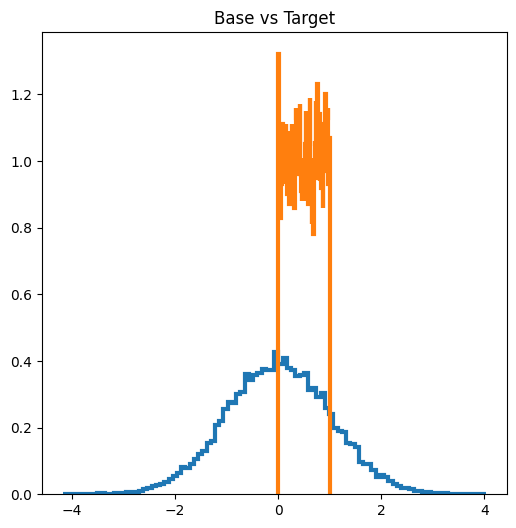

In [6]:
fig = plt.figure(figsize=(6,6,))
plt.hist(base_samples, 100, histtype="step", density=True, lw=3,  label = 'base');
plt.hist(target_samples, 100, histtype="step", density=True, lw=3,  label = 'target');
# plt.scatter(target_samples[:,0], target_samples[:,1], alpha = 0.2);
plt.title("Base vs Target")
plt.show()

In [7]:
def gen_samples(c0, d0, dt, bins, nsteps, nparticles=1000):
    hists = torch.zeros((nsteps, bins))
    randn_samps = torch.randn((nsteps, nparticles))
    pos = randn_samps[0]*d0+c0
    pos[pos>1] = 1-(pos[pos>1]%1)
    pos[pos<0] = 1-(pos[pos<0]%1)
    hists[0] = torchist.histogram(pos, bins=bins, low=0, upp=1)
    
    for i in range(1, nsteps):
        pos += dt**0.5*randn_samps[i]
        pos[pos>1] = 1-(pos[pos>1]%1)
        pos[pos<0] = 1-(pos[pos<0]%1)
        hists[i] = torchist.histogram(pos, bins=bins, low=0, upp=1)

    base = hists[:-1]
    target = hists[1:]
    
    return base, target

In [8]:
(torch.randn((10,100))*torch.arange(10).unsqueeze(1)).std(1)

tensor([0.0000, 1.0899, 1.9787, 3.0109, 3.8652, 5.1229, 4.9156, 6.6655, 7.6403,
        8.7012])

In [9]:
def gen_samples(c0, d0, dt, bins, nsteps, nparticles=1000):
    hists = torch.zeros((nsteps, bins))
    randn_samps = torch.randn((nsteps, nparticles))
    pos = randn_samps[0]*d0+c0
    pos[pos>1] = 1-(pos[pos>1]%1)
    pos[pos<0] = 1-(pos[pos<0]%1)
    hists[0] = torchist.histogram(pos, bins=bins, low=0, upp=1)
    
    for i in range(1, nsteps):
        pos += dt**0.5*randn_samps[i]
        pos[pos>1] = 1-(pos[pos>1]%1)
        pos[pos<0] = 1-(pos[pos<0]%1)
        hists[i] = torchist.histogram(pos, bins=bins, low=0, upp=1)

    base = hists[:-1]
    target = hists[1:]
    
    return base, target

### Define Interpolant: A one sided interpolant, meaning that $x_0 \sim N(0,1)$

In [10]:
# gamma_type = 'brownian'
path = 'one-sided-linear'
interpolant  = stochastic_interpolant.Interpolant(path=path, gamma_type=None)

### Define losses for b and s

In [11]:
loss_fn_b = stochastic_interpolant.make_loss(method='shared', interpolant = interpolant, loss_type='one-sided-b')
loss_fn_s = stochastic_interpolant.make_loss(method='shared', interpolant = interpolant, loss_type='one-sided-s')

### Define velocity field and optimizers

In [12]:
ndim = 16
base_lr      = 1e-2
hidden_sizes = [16, 16]
in_size      = (ndim+1)
out_size     = (ndim)
inner_act    = 'relu'
final_act    = 'none'
print_model  = False


b       = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
s       = itf.fabrics.make_fc_net(hidden_sizes=hidden_sizes, in_size=in_size, out_size=out_size, inner_act=inner_act, final_act=final_act)
opt_b   = torch.optim.Adam(b.parameters(), lr=base_lr)
opt_s   = torch.optim.Adam(s.parameters(), lr=base_lr)
sched_b = torch.optim.lr_scheduler.StepLR(optimizer=opt_b, step_size=1500, gamma=0.4)
sched_s = torch.optim.lr_scheduler.StepLR(optimizer=opt_s, step_size=1500, gamma=0.4)


eps          = torch.tensor(0.5)
N_era        = 14
N_epoch      = 500
plot_bs      = 1000  # number of samples to use when plotting
bs           = 2000    # number of samples from rho_0 in batch
metrics_freq = 50    # how often to log metrics, e.g. if logp is not super cheap don't do it everytime
plot_freq    = 500   # how often to plot
n_save       = 10    # how often to checkpoint SDE integrator
loss_fac     = 4.0   # ratio of learning rates for w to v
n_step       = 100   # number of steps taken by the SDE in [0,1]


if print_model:
    print("Here's the model b, s:", b, s)

[Loss: 0.031135024000832345], [Backprop: 0.04406745500455145], [Update: 0.034274354999070056].
EPOCH: 1
LOSS, GRAD: tensor(2255.2322) tensor([2666.3032]) tensor([51646.9883])


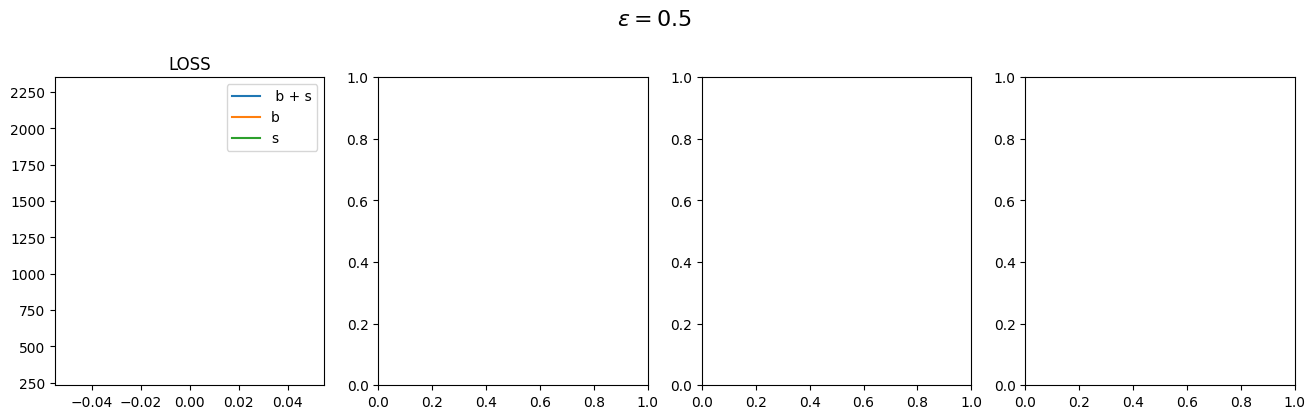

[Loss: 0.002199379996454809], [Backprop: 0.0020971510020899586], [Update: 0.0009324049970018677].
[Loss: 0.0031267009981092997], [Backprop: 0.0025929210023605265], [Update: 0.0009807400056160986].
[Loss: 0.002085999003611505], [Backprop: 0.0022253560018725693], [Update: 0.0009607669999240898].
EPOCH: 501
LOSS, GRAD: tensor(-238810.1406) tensor([133.9289]) tensor([311226.3125])


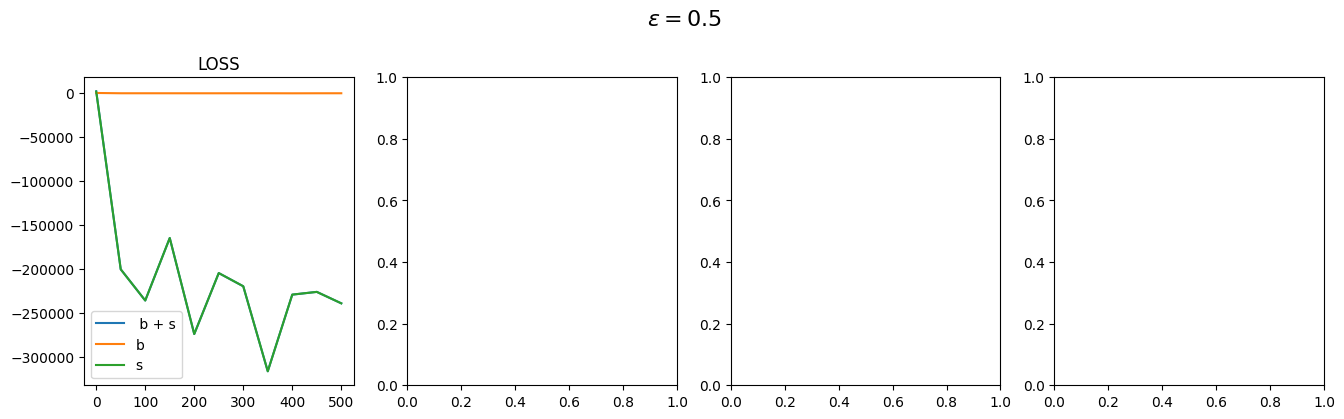

EPOCH: 1001
LOSS, GRAD: tensor(-418510.) tensor([1.6003]) tensor([974535.5625])


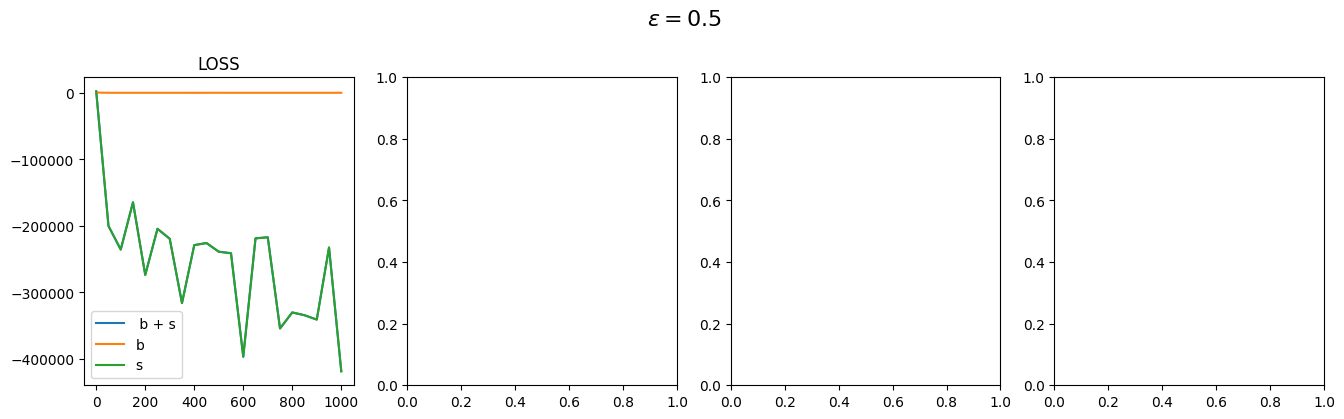

EPOCH: 1501
LOSS, GRAD: tensor(-102345.5469) tensor([59.3179]) tensor([1632646.])


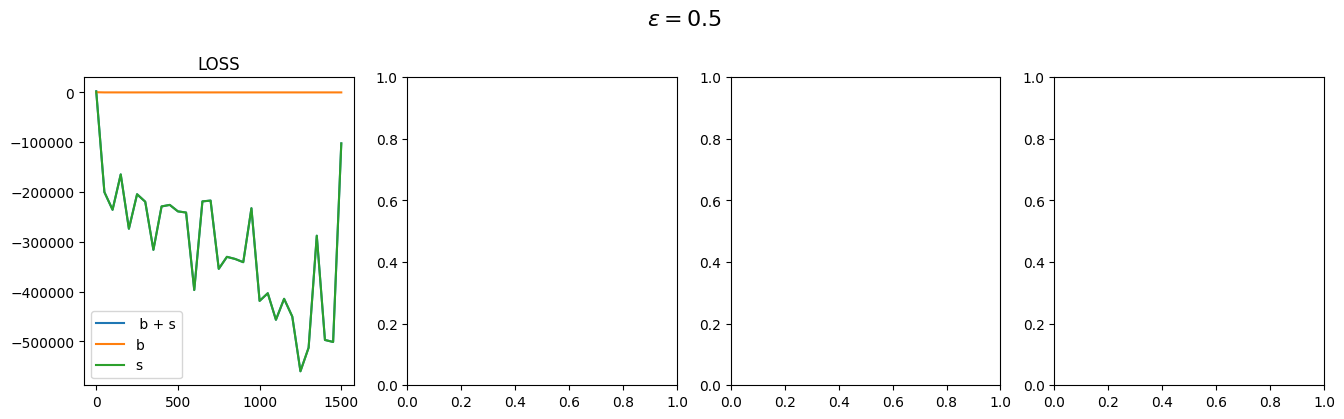

EPOCH: 2001
LOSS, GRAD: tensor(-626022.9375) tensor([1.2076]) tensor([4287555.])


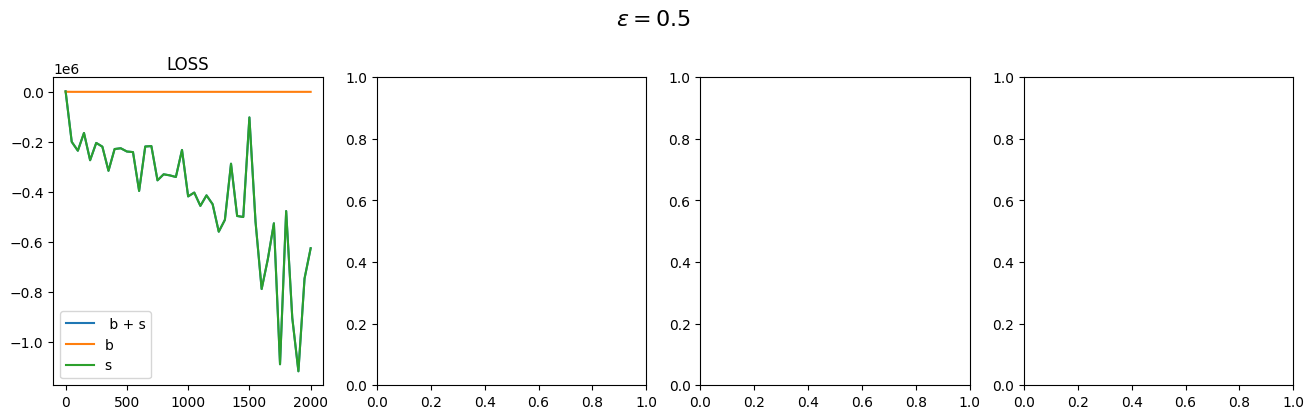

EPOCH: 2501
LOSS, GRAD: tensor(-644312.9375) tensor([1.8308]) tensor([8947232.])


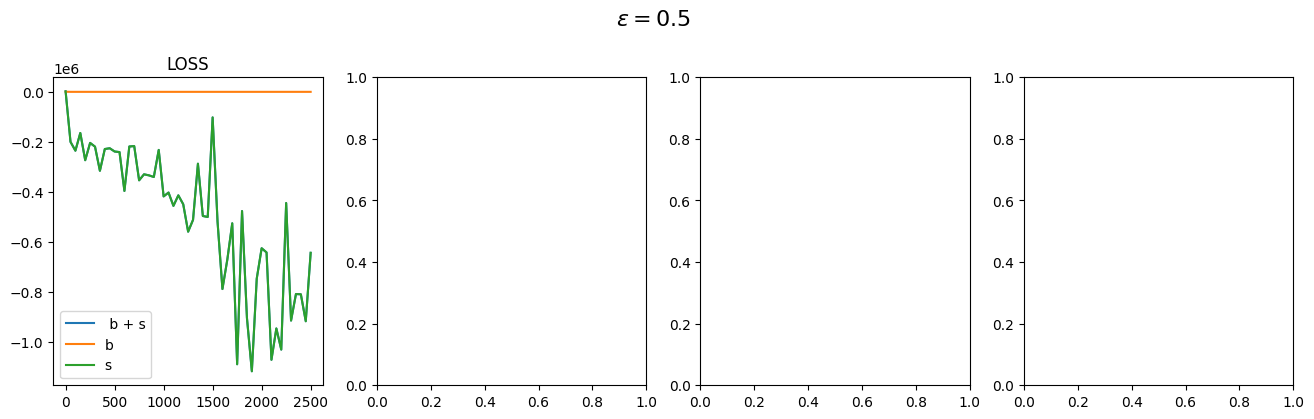

EPOCH: 3001
LOSS, GRAD: tensor(-1510315.5000) tensor([11.8232]) tensor([16067061.])


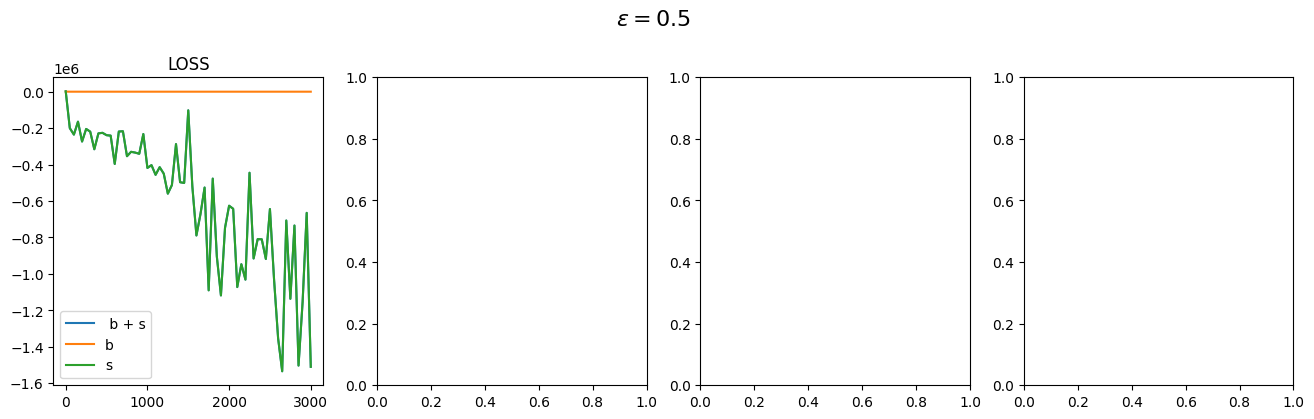

EPOCH: 3501
LOSS, GRAD: tensor(-1522507.) tensor([50.4790]) tensor([6352521.])


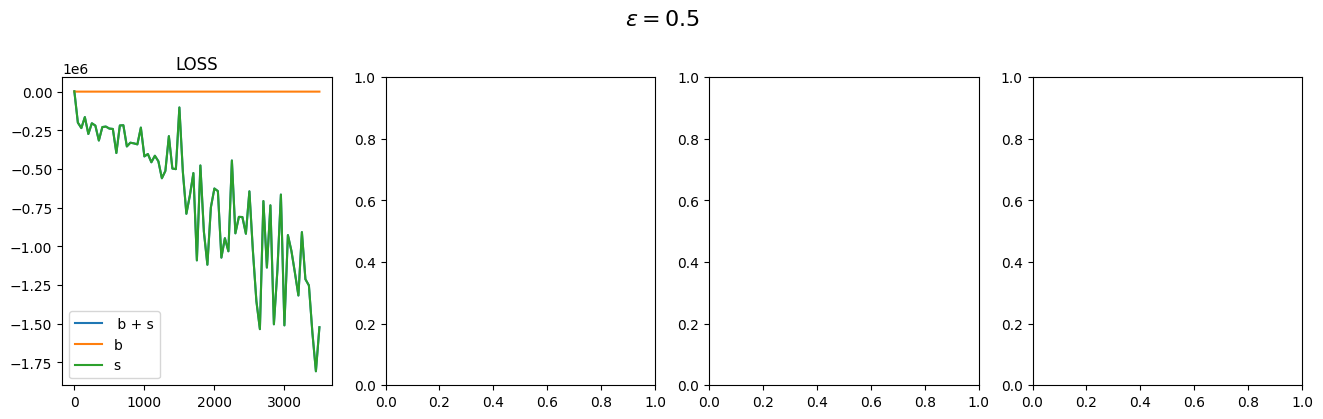

EPOCH: 4001
LOSS, GRAD: tensor(-1290785.1250) tensor([1.1347]) tensor([2034707.])


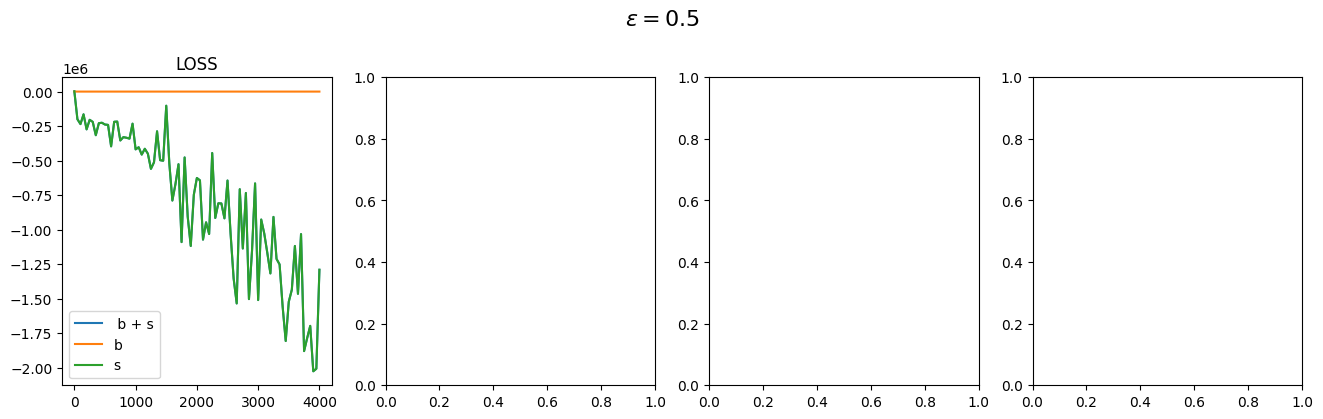

EPOCH: 4501
LOSS, GRAD: tensor(-2357153.5000) tensor([62.7159]) tensor([11934397.])


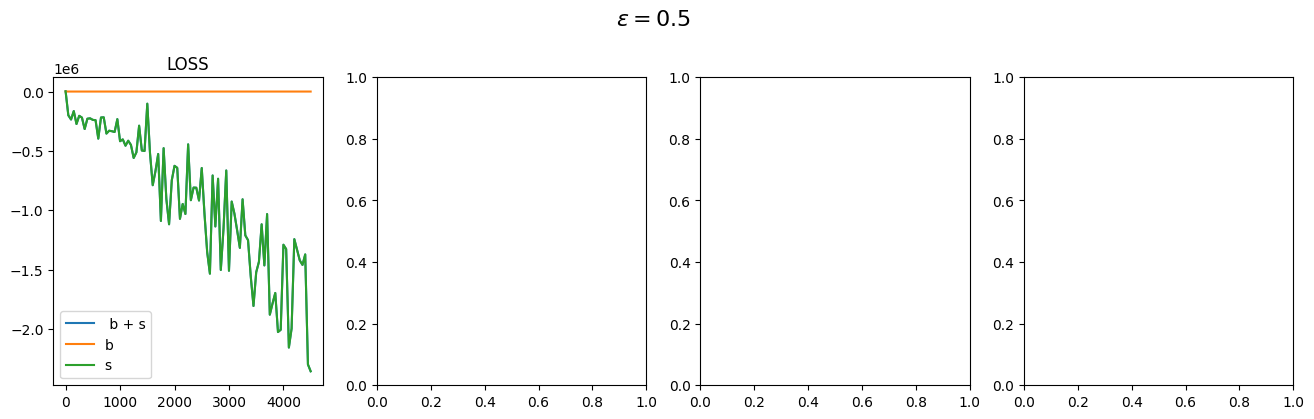

EPOCH: 5001
LOSS, GRAD: tensor(-1509355.5000) tensor([18.6708]) tensor([845968.8750])


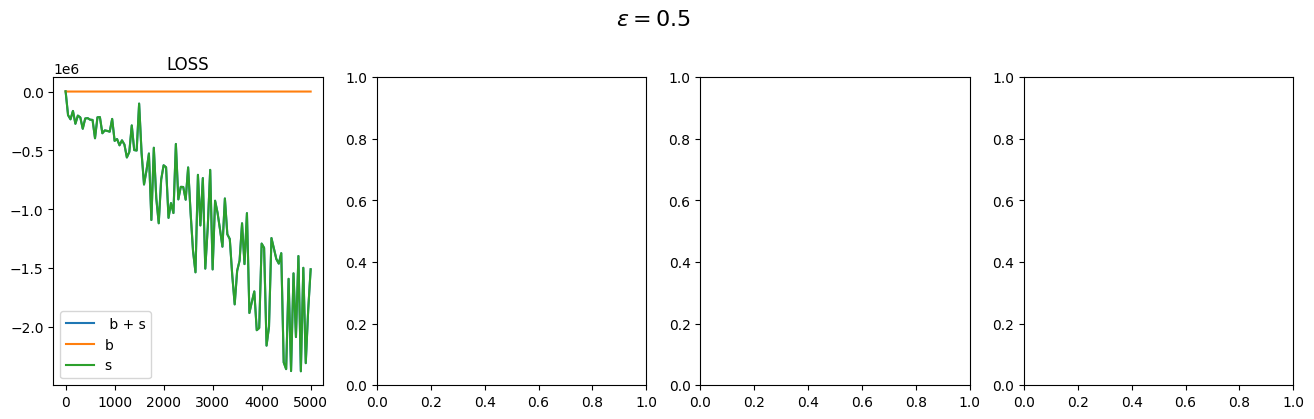

EPOCH: 5501
LOSS, GRAD: tensor(-1609775.) tensor([1.8073]) tensor([3095677.2500])


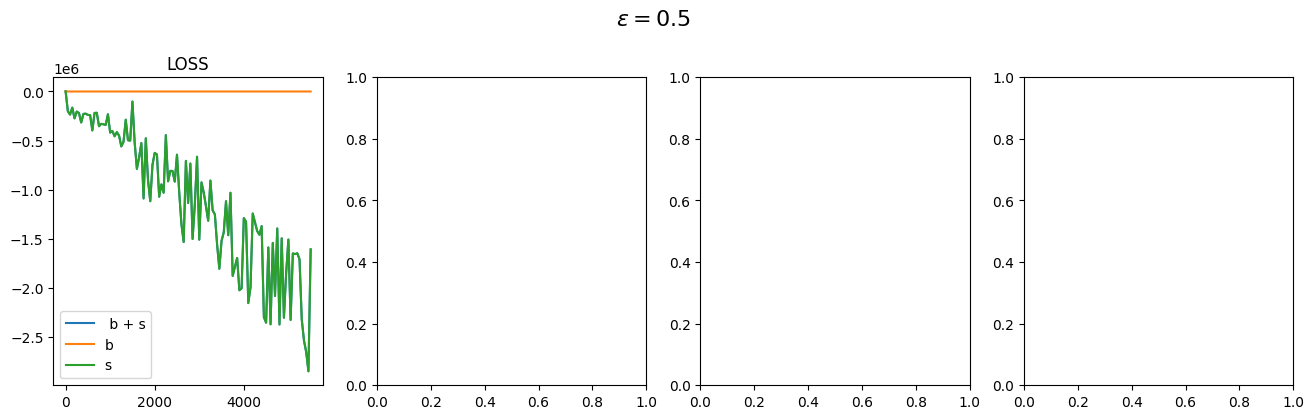

EPOCH: 6001
LOSS, GRAD: tensor(-2450669.5000) tensor([1.7654]) tensor([3423032.5000])


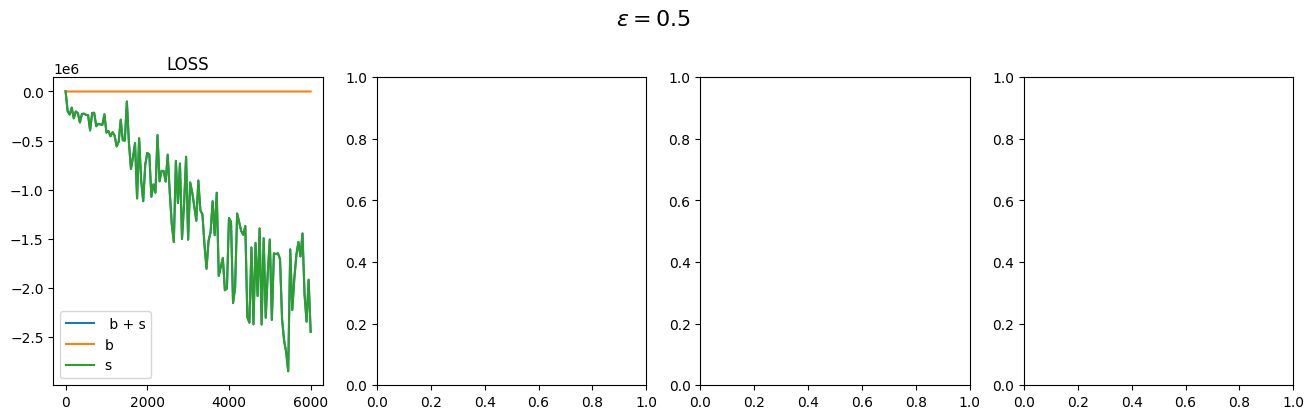

KeyboardInterrupt: 

In [13]:
data_dict = {
    'losses': [],
    'b_losses': [],
    's_losses': [],
    'b_grads': [],
    's_grads': [],
    'times': [],
    'logps_pflow': [],
}

counter = 1
for i, era in enumerate(range(N_era)):
    for j, epoch in enumerate(range(N_epoch)):
        loss, b_loss, s_loss, b_grad, s_grad = train_step(bs, interpolant, opt_b, opt_s, sched_b, sched_s,
        )


        if (counter - 1) % metrics_freq == 0:
            log_metrics(b, s, interpolant, n_save, n_step, bs, b_loss, 
                        s_loss, loss, b_grad, s_grad, eps, data_dict)


        if (counter - 1) % plot_freq == 0:
            make_plots(b, s, interpolant, n_save, n_step, plot_bs, counter, metrics_freq, eps, data_dict)


        counter+=1

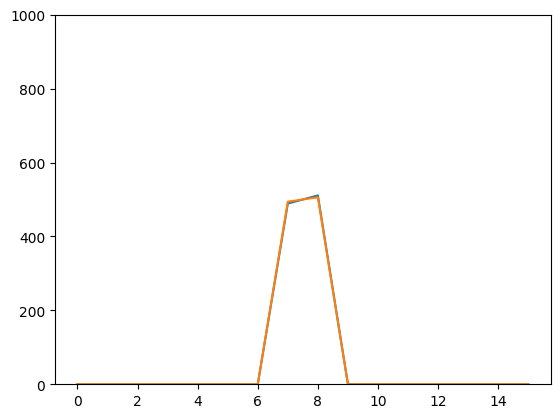

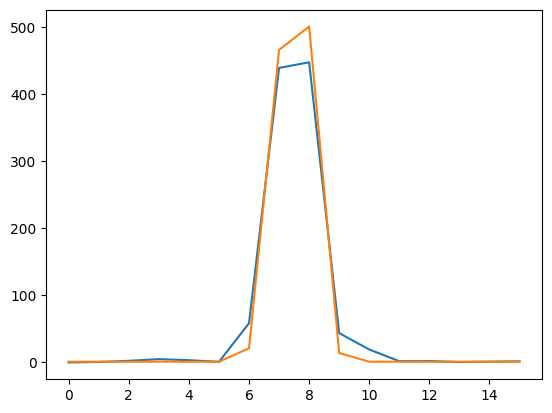

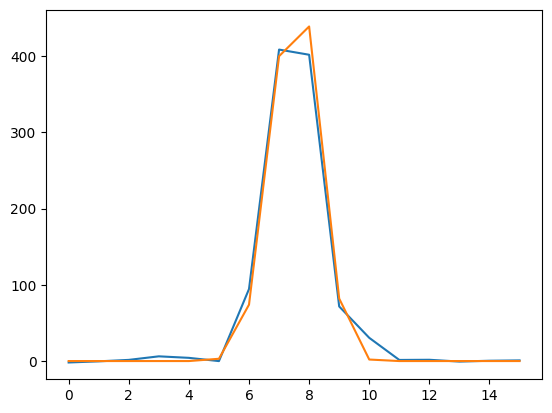

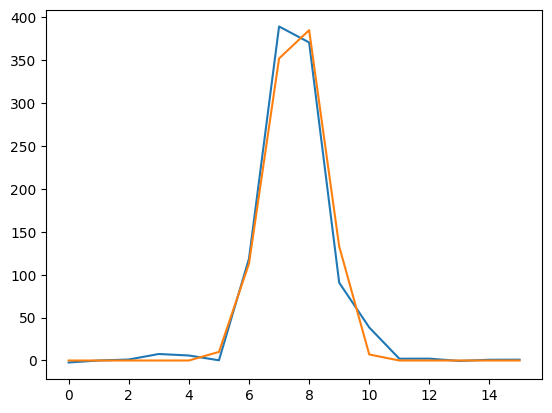

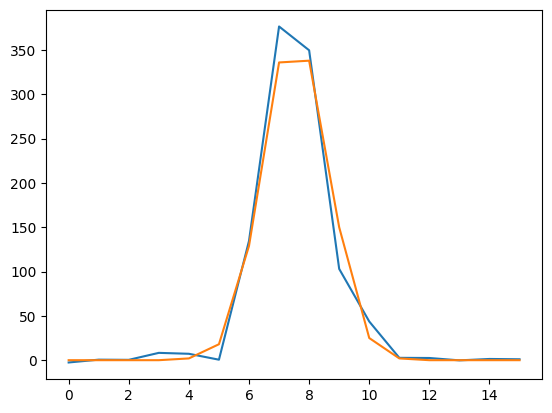

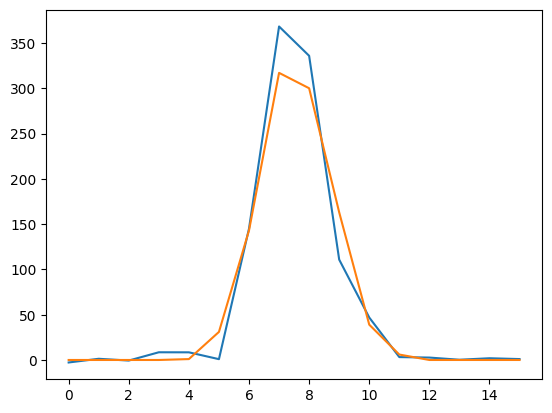

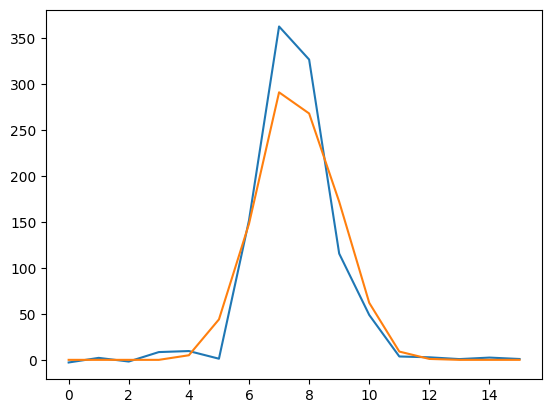

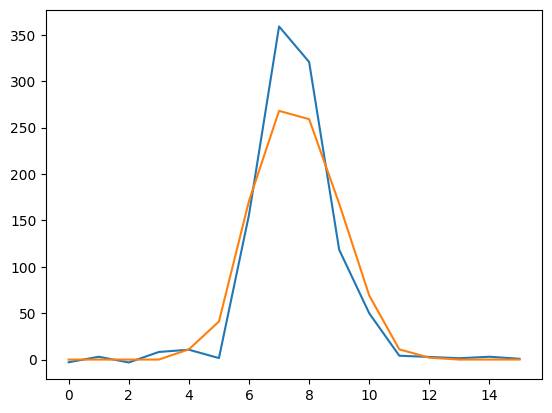

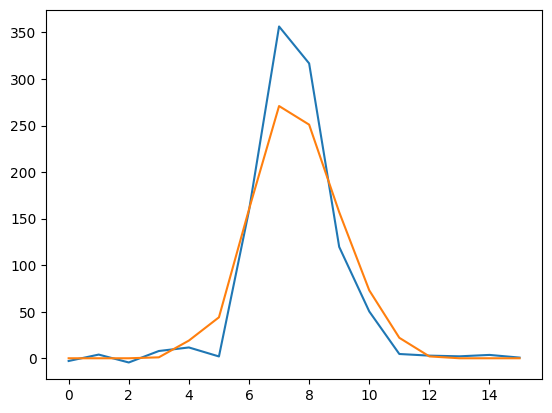

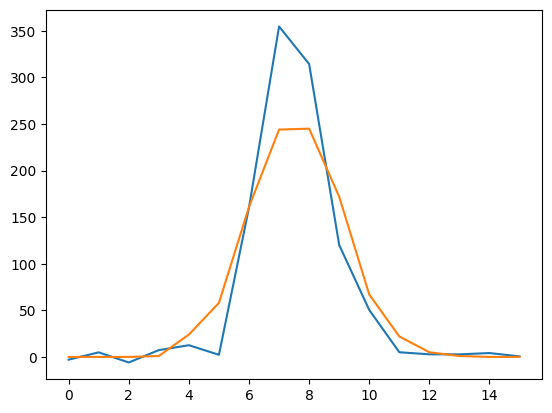

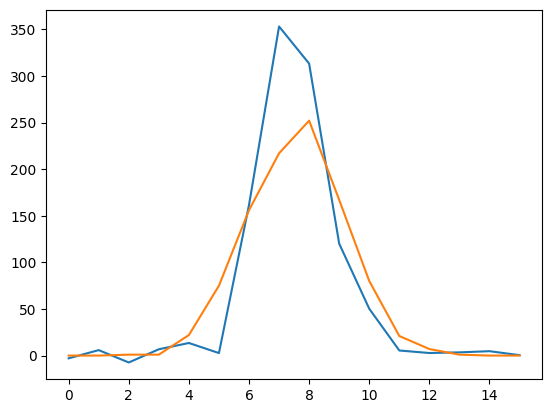

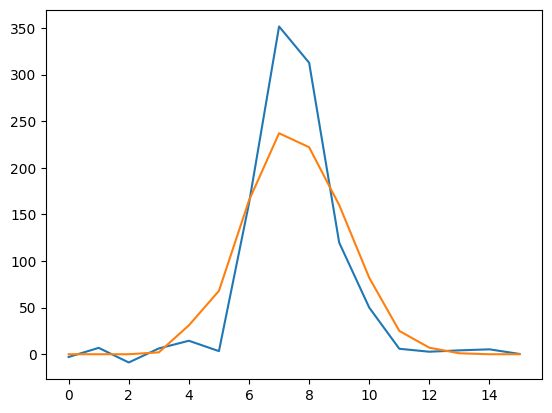

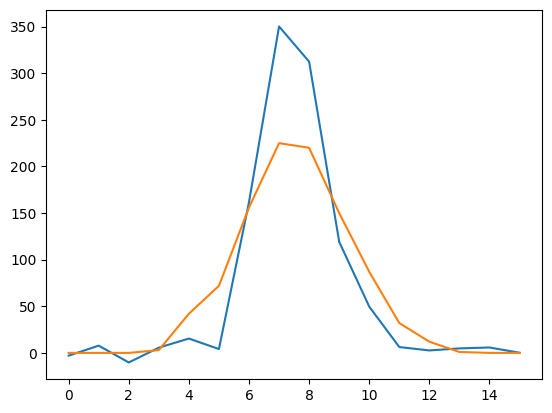

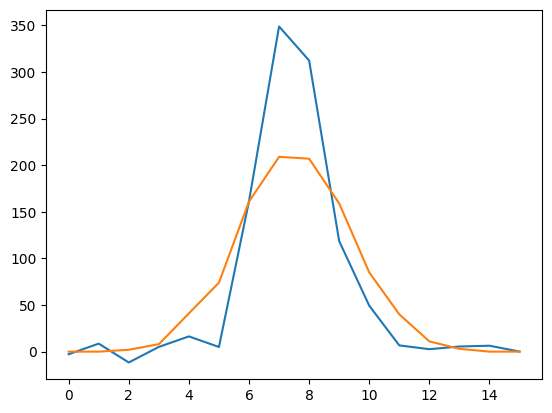

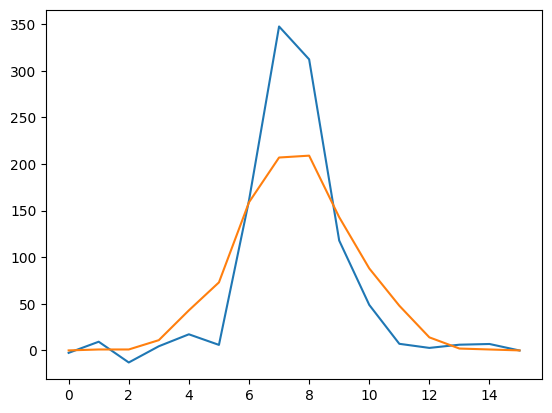

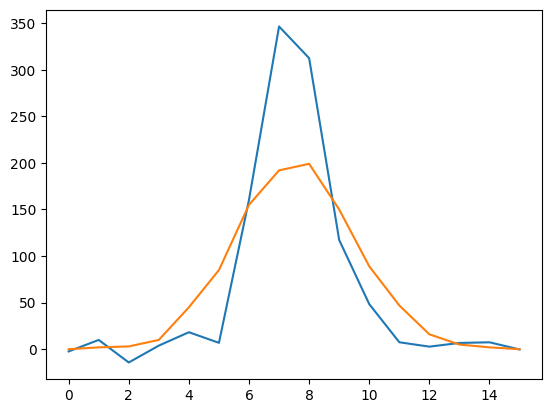

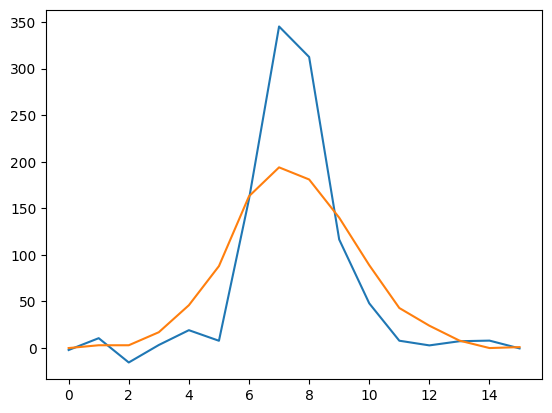

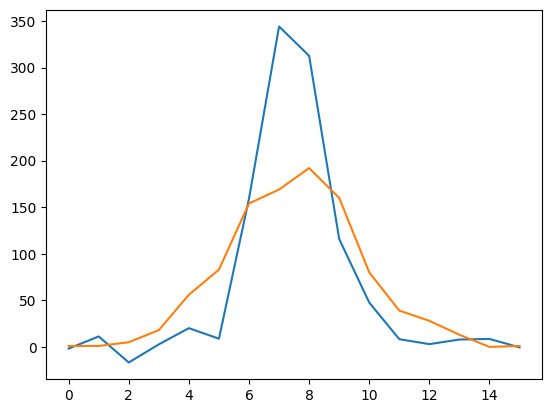

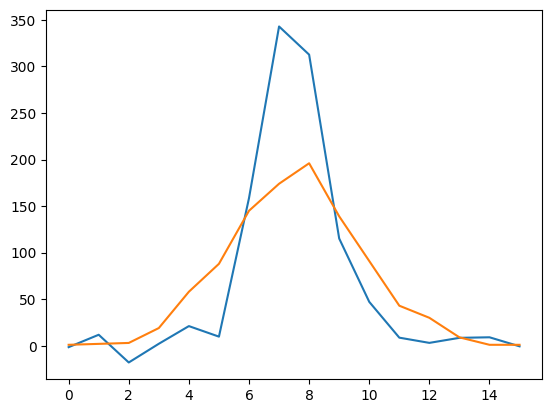

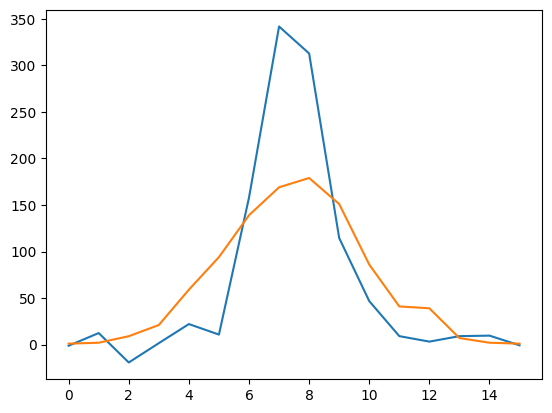

IndexError: index 200 is out of bounds for dimension 0 with size 199

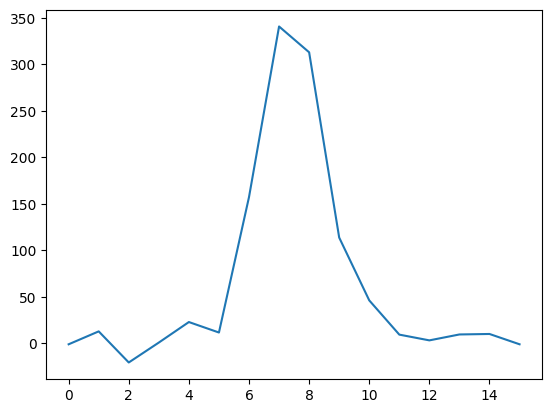

In [14]:
samp = gen_samples(0.5, 1e-3, 1e-4, 16, 2, 1000)[0]
samp2 = gen_samples(0.5, 1e-3, 1e-4, 16, 200, 1000)[0]
plt.plot(samp.detach().squeeze().cpu())
plt.plot(samp2[0].squeeze().cpu())
plt.ylim(0, 1000)
plt.show()

for i in range(20):
    for j in range(10):
        samp = rollout(samp, b, s, interpolant, n_save, n_step, eps, bs)[1]
    plt.plot(samp.detach().squeeze().cpu())
    plt.plot(samp2[10*(i+1)].cpu())
    # plt.ylim(0, 1000)
    plt.show()
    
# # rollout(, b, s, interpolant, n_save, n_step, eps, bs)[1]

In [271]:
x0_tests, xf_sde, xf_pflow, logpx_pflow = compute_likelihoods2(b, s, interpolant, n_save, n_step, eps, bs)

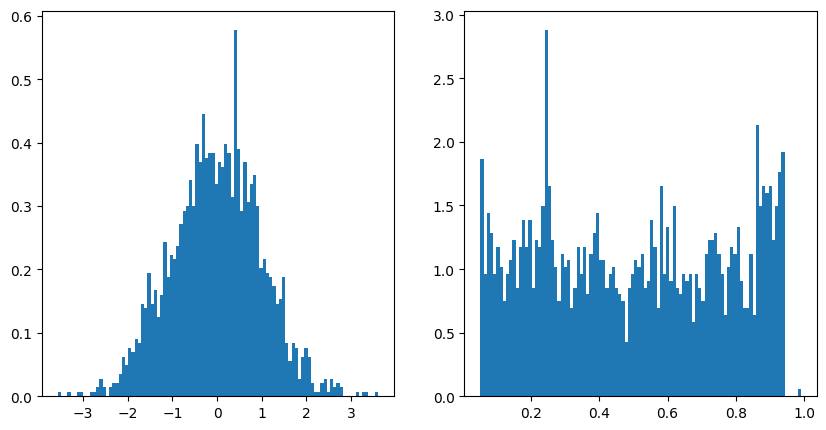

In [272]:
plt.subplots(1, 2, figsize=(10,5))
plt.subplot(1, 2, 1)
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)
# plt.gca().set_aspect(1)
plt.hist(x0_tests.cpu(), 100, density=True)
plt.subplot(1, 2, 2)
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)
# plt.gca().set_aspect(1)
plt.hist(xf_sde, 100, density=True)
plt.show()

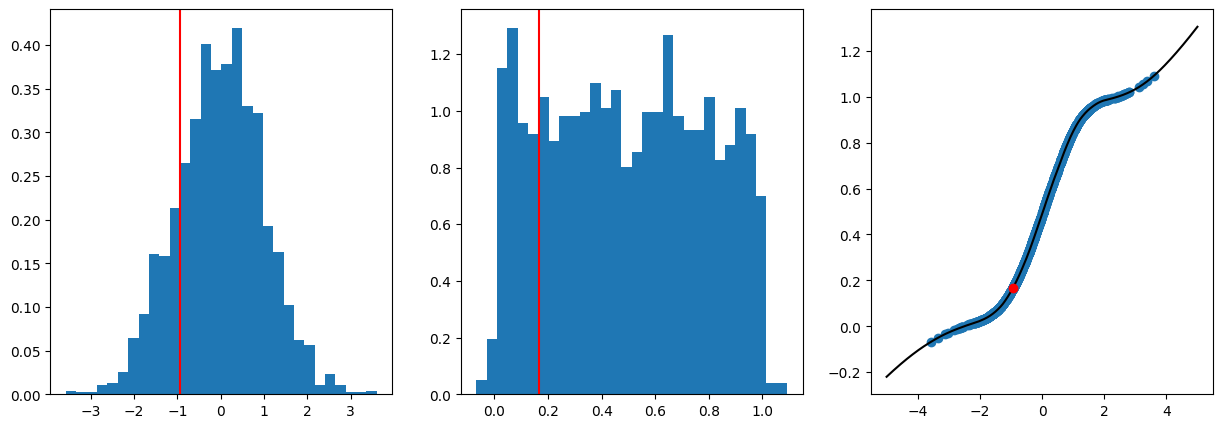

In [278]:
plt.subplots(1, 3, figsize=(15,5))
plt.subplot(1, 3, 1)
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)
# plt.gca().set_aspect(1)
plt.hist(x0_tests.cpu(), 30, density=True)
plt.axvline(x0_tests.cpu()[700], color="r")
plt.subplot(1, 3, 2)
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)
# plt.gca().set_aspect(1)
plt.hist(xf_pflow, 30, density=True)
plt.axvline(xf_pflow[700], color="r")
plt.subplot(1, 3, 3)
plt.plot(x0_tests.cpu(), xf_pflow, "o")
x = torch.linspace(-5, 5, 2000).unsqueeze(1).cuda()
f = rollout(x, b, s, interpolant, n_save, n_step, eps, bs)
plt.plot(f[0].cpu(), f[2], c="k", zorder=2)
plt.scatter(x0_tests.cpu()[700], xf_pflow[700], c="r", zorder=2)
plt.show()

In [169]:
from scipy.special import erf

In [556]:
ptx = lambda t, x: (erf(x/(2**0.5*(1-t)))+erf((x-t)/(2**0.5*(t-1))))/(2*t)
mean_dinterpdt = lambda t, x: (2*(np.exp(-x**2/(2*(t-1)**2))-np.exp(-(t-x)**2/(2*(t-1)**2)))+(2*np.pi)**0.5*x*(erf(x/(2**0.5*(1-t)))-erf((t-x)/(2**0.5*(t-1)))))/(2*(2*np.pi)**0.5*t**2)/ptx(t,x)

In [494]:
a = 4
b = 0.1
ptx = lambda t, x: np.exp(-(x-a*t)**2/(2*((1-t)**2+t**2*b**2)))/np.sqrt(2*np.pi*((1-t)**2+t**2*b**2))
mean_dinterpdt = lambda t, x: -np.exp(-((-a*t+x)**2/(2+2*t*(-2+t+b**2*t))))*(a*(-1+t)+x-(1+b**2)*t*x)/(np.sqrt(2*np.pi*(1+t*(-2+t+b**2*t))**3))/ptx(t,x)

In [557]:
from scipy.integrate import solve_ivp

In [558]:
sol = solve_ivp(mean_dinterpdt, [1e-4, 1-1e-4], np.ones(1)*-1, method="RK45")

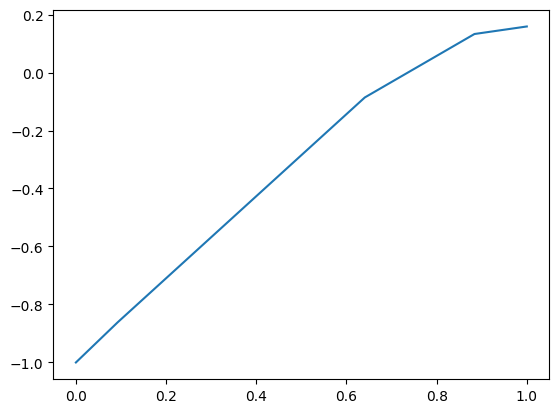

In [559]:
plt.plot(sol.t, sol.y.T)

In [560]:
# x0 = np.random.randn(2000)
sol_samps = solve_ivp(mean_dinterpdt, [1e-6, 1-1e-6], y0=x0_tests.cpu().squeeze())

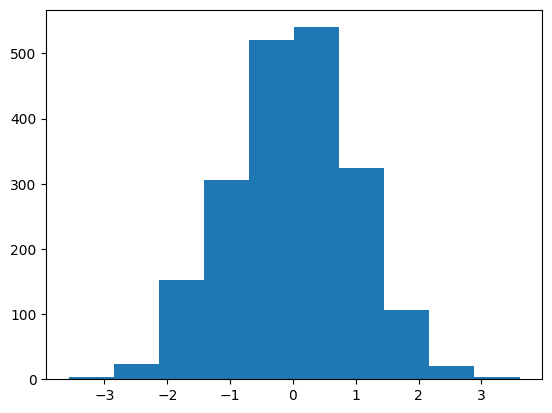

In [561]:
plt.hist(x0_tests.squeeze().cpu())
plt.show()

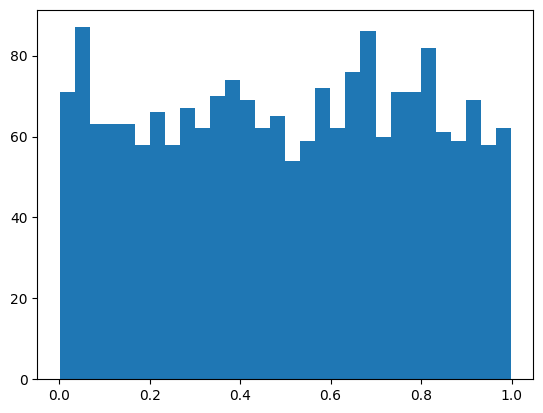

In [564]:
plt.hist(sol_samps.y.T[-1], 30)
plt.show()

/tmp/ipykernel_145177/2901992503.py:2: RuntimeWarning: divide by zero encountered in divide
  mean_dinterpdt = lambda t, x: (2*(np.exp(-x**2/(2*(t-1)**2))-np.exp(-(t-x)**2/(2*(t-1)**2)))+(2*np.pi)**0.5*x*(erf(x/(2**0.5*(1-t)))-erf((t-x)/(2**0.5*(t-1)))))/(2*(2*np.pi)**0.5*t**2)/ptx(t,x)
/tmp/ipykernel_145177/2901992503.py:2: RuntimeWarning: invalid value encountered in divide
  mean_dinterpdt = lambda t, x: (2*(np.exp(-x**2/(2*(t-1)**2))-np.exp(-(t-x)**2/(2*(t-1)**2)))+(2*np.pi)**0.5*x*(erf(x/(2**0.5*(1-t)))-erf((t-x)/(2**0.5*(t-1)))))/(2*(2*np.pi)**0.5*t**2)/ptx(t,x)


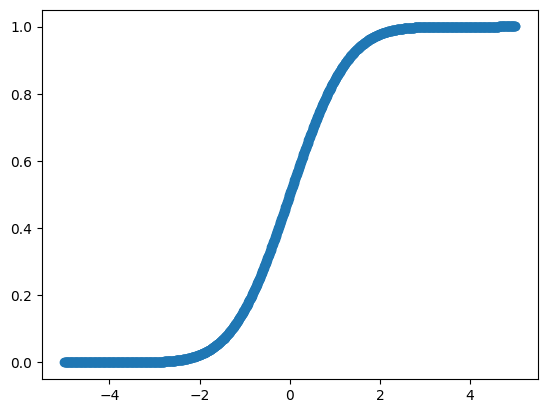

In [565]:
x0 = np.linspace(-5, 5, 1000)
sol = solve_ivp(mean_dinterpdt, [1e-4, 1-1e-4], y0=x0)
plt.scatter(x0, sol.y.T[-1])

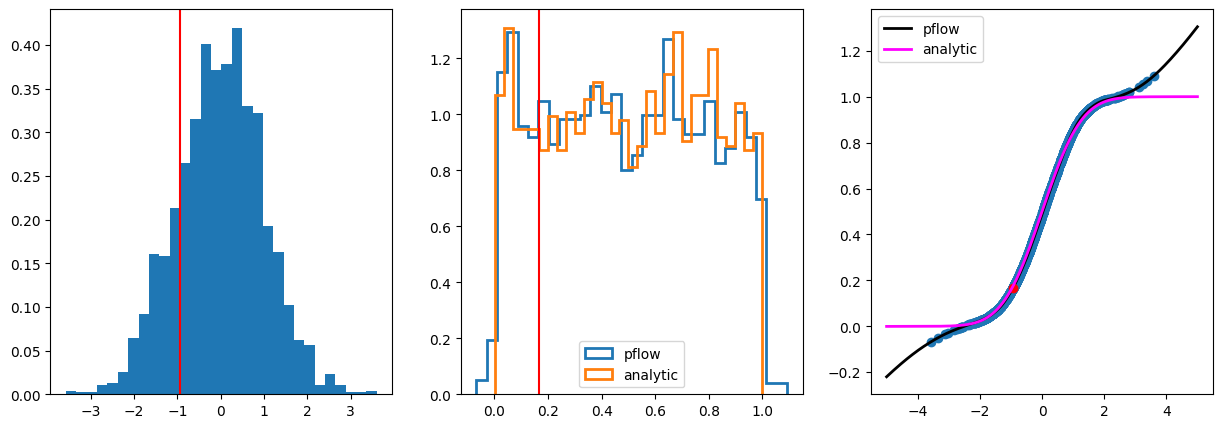

In [570]:
plt.subplots(1, 3, figsize=(15,5))
plt.subplot(1, 3, 1)
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)
# plt.gca().set_aspect(1)
plt.hist(x0_tests.cpu(), 30, density=True)
plt.axvline(x0_tests.cpu()[700], color="r")
plt.subplot(1, 3, 2)
# plt.xlim(-5, 5)
# plt.ylim(-5, 5)
# plt.gca().set_aspect(1)
plt.hist(xf_pflow, 30, density=True, histtype="step", lw=2, label="pflow")
plt.hist(sol_samps.y.T[-1], 30, density=True, histtype="step", lw=2, label="analytic")
plt.legend()
plt.axvline(xf_pflow[700], color="r")
plt.subplot(1, 3, 3)
plt.plot(x0_tests.cpu(), xf_pflow, "o")
x = torch.linspace(-5, 5, 2000).unsqueeze(1).cuda()
# f = rollout(x, b, s, interpolant, n_save, n_step, eps, bs)
plt.plot(f[0].cpu(), f[2], c="k", zorder=2, lw=2, label="pflow")
plt.scatter(x0_tests.cpu()[700], xf_pflow[700], c="r", zorder=2)
plt.plot(x0, sol.y.T[-1], c="magenta", lw=2, label="analytic")
plt.legend()
plt.show()